# Imports and Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

# Setting Parameters

In [2]:
S0 = 100      # initial stock price
K = 100       # strike price
sigma = 0.15  # volatility
r = 0.03      # risk-free rate
mu = r        # drift set to risk-free rate for risk-neutral measure
M = 1         # maturity in years
T = 50        # number of time steps
N_MC = 10000  # number of paths
degree = 3    # degree of polynomial basis functions
num_iters = 5 # number of Fitted Q-Iteration iterations (multiple backward passes)
delta_t = M / T                # time interval
gamma = np.exp(-r * delta_t)  # discount factor

# Black-Scholes Put Price Function
Purpose: Implements the Black-Scholes formula for a European put option, used as a reference to compare with the American option price.

In [3]:
def bs_put(t, S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * (T-t)) / (sigma * np.sqrt(T-t))
    d2 = d1 - sigma * np.sqrt(T-t)
    return K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Basis Functions
Purpose: Creates a matrix of polynomial basis functions for regression.
* Input X: Array of stock prices or state variables.
* Input degree: Maximum polynomial degree (e.g., 3).
* Output: A matrix where each column is $ X^k $ for $ k = 0, 1, \ldots, \text{degree} $.
* Example: For degree=3, the matrix has columns $ [1, X, X^2, X^3] $.
* Used to approximate the continuation value in Fitted Q-Iteration via least-squares regression.

In [4]:
def basis_functions(X, degree):
    return np.column_stack([X**k for k in range(degree + 1)])

# Simulate Stock Price Paths
Purpose: Simulates 10,000 stock price paths using the geometric Brownian motion model under the risk-neutral measure.
* Z: Generates $ N_{MC} \times T $ standard normal random variables for stochastic increments.
* S: Array of shape $ (N_{MC}, T+1) $ to store stock prices at times $ t=0, 1, \ldots, T $.
* Initializes S[:, 0] = S0 (all paths start at $100$).
* For each time step $ t $, computes:
 $$S_{t+1} = S_t \exp\left( \left( \mu - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \sqrt{\Delta t} Z_t \right)$$
 This is the discretized Black-Scholes model, where $ \mu = r $.

In [5]:
np.random.seed(42)
Z = np.random.normal(0, 1, (N_MC, T))
S = np.zeros((N_MC, T + 1))
S[:, 0] = S0
for t in range(T):
    S[:, t + 1] = S[:, t] * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Z[:, t])

# Compute payoff (for a put option)
Purpose: Calculates the payoff of a put option for each path at each time step.
* For a put option, payoff at time $ t $ is $ \max(K - S_t, 0) $.
* payoff is an array of shape $ (N_{MC}, T+1) $, where each element is the intrinsic value of the option if exercised at that time.

In [6]:
payoff = np.maximum(K - S, 0)

# Fitted Q-Iteration for American Option Pricing
Purpose: Initializes arrays for the option value and continuation value.
* V: Stores the option value $ V_t(s) $, which is the maximum of the exercise value and continuation value at each time step.
* Q_cont: Stores the continuation value $ Q_{\text{cont}}(s) $, the expected value of continuing (not exercising) the option.
* At maturity ($ t=T $), the option value equals the payoff ($ V_T = \max(K - S_T, 0) $), and the continuation value is 0 (no future steps to continue to).

In [7]:
V = np.zeros_like(payoff)
Q_cont = np.zeros_like(payoff)
V[:, T] = payoff[:, T]
Q_cont[:, T] = 0  # No continuation at maturity

Purpose: Implements Fitted Q-Iteration to compute the option value.
* Outer Loop (iter_k): Runs num_iters (5) iterations to refine the value function, a key feature of Fitted Q-Iteration that iteratively improves the approximation.
* Inner Loop (t): Iterates backward from $ t = T-1 $ to $ t = 0 $.
* In-the-Money Check (itm): Identifies paths where the option is in-the-money ($ \max(K - S_t, 0) > 0 $).
* Regression for Continuation Value:
  - For in-the-money paths, constructs basis functions using stock prices $ S_t $.
  - Targets are the discounted option values at the next time step ($ \gamma V_{t+1} $).
  - Uses least-squares regression (np.linalg.lstsq) to fit a polynomial to approximate $ Q_{\text{cont}}(s_t) $.
  - Stores the fitted continuation value in Q_cont[itm, t].
* Out-of-the-Money Paths: For paths where $ \max(K - S_t, 0) = 0 $, sets $ Q_{\text{cont}} = \gamma V_{t+1} $, as the optimal action is to continue.
* Option Value Update: Sets $ V_t = \max(\text{payoff}_t, Q_{\text{cont},t}) $, reflecting the American option's choice to exercise or continue.
* Why Multiple Iterations?: Fitted Q-Iteration refines the value function by repeatedly updating $ Q_{\text{cont}} $ and $ V $, improving accuracy over multiple backward passes, unlike the single-pass approach in Least Squares Monte Carlo (LSM).

In [8]:
for iter_k in range(num_iters):
    for t in range(T - 1, -1, -1):
        itm = payoff[:, t] > 0  # In-the-money paths
        basis = basis_functions(S[itm, t], degree)
        targets = gamma * V[itm, t + 1]
        if np.any(itm):
            reg = np.linalg.lstsq(basis, targets, rcond=None)[0]
            Q_cont[itm, t] = np.dot(basis, reg)
        Q_cont[~itm, t] = gamma * V[~itm, t + 1]  # For OTM, always continue
        V[:, t] = np.maximum(payoff[:, t], Q_cont[:, t])

# Option Price
* Purpose: Computes the American put option price as the average of the option values at $ t=0 $ across all paths.
* $ V[:, 0] $ contains the option value for each path at the initial time, and the mean approximates the expected value under the risk-neutral measure.

In [9]:
option_price = np.mean(V[:, 0])

# Determine Exercise Decisions
Purpose: Determines when to exercise the option for each path.
* exercise is a boolean array of shape $ (N_{MC}, T) $.
* At each time $ t $, exercise if the payoff exceeds the continuation value ($ \text{payoff}_t > Q_{\text{cont},t} $) and the option is in-the-money ($ \text{payoff}_t > 0 $).
* This reflects the optimal exercise policy for an American option.

In [10]:
exercise = np.zeros((N_MC, T), dtype=bool)
for t in range(T):
    exercise[:, t] = (payoff[:, t] > Q_cont[:, t]) & (payoff[:, t] > 0)

# Compute Optimal Hedge
Purpose: Initializes arrays for hedging and portfolio tracking.
* hedge: Stores the hedge ratio $ a_t $, the number of shares to hold in the stock.
* portfolio: Tracks the value of the replicating portfolio over time.
* cash: Tracks the cash account in the replicating portfolio.
* At $ t=0 $, the portfolio and cash are initialized to the option price.

In [11]:
hedge = np.zeros((N_MC, T))
portfolio = np.zeros((N_MC, T + 1))
portfolio[:, 0] = option_price  # Initial portfolio value
cash = np.zeros((N_MC, T + 1))
cash[:, 0] = option_price  # Initially all in cash

Purpose: Computes the optimal hedge and updates the replicating portfolio.
* Alive Paths: Identifies paths where the option has not been exercised up to time $ t-1 $ (alive).
* Fit Continuation Value: For alive paths, fits a polynomial to $ \gamma V_{t+1} $ using basis functions.
* Hedge Calculation:
   - Computes the derivative of the continuation value with respect to the stock price:
   - $$\frac{dQ_{\text{cont}}}{dS} = \sum_{k=1}^{\text{degree}} k \cdot \text{reg}[k] \cdot S_t^{k-1}$$
   - This derivative approximates the delta ($ \frac{dV}{dS} $) for paths that continue, as $ V_t \approx Q_{\text{cont},t} $ when not exercising.
   - Sets hedge[alive, t] = dQ_dS, the number of shares to hold.
* Portfolio and Cash Update:
   - Cash at time $ t $: $ \text{cash}_t = \text{portfolio}_t - a_t S_t $.
   - Portfolio at time $ t+1 $: $ \text{portfolio}_{t+1} = a_t S_{t+1} + \text{cash}_t e^{r \Delta t} $. 
* Exercised Paths: For paths already exercised, the portfolio earns the risk-free rate: $ \text{portfolio}_{t+1} = \text{portfolio}_t e^{r \Delta t} $.

In [12]:
for t in range(T):
    alive = ~np.any(exercise[:, :t], axis=1)  # Paths not yet exercised up to t-1
    if np.any(alive):
        # Fit continuation value at t
        basis_alive = basis_functions(S[alive, t], degree)
        targets_alive = gamma * V[alive, t + 1]
        reg = np.linalg.lstsq(basis_alive, targets_alive, rcond=None)[0]

        # Compute dQ_cont / dS = sum k * reg[k] * S^(k-1)
        dQ_dS = np.zeros(np.sum(alive))
        for k in range(1, degree + 1):
            dQ_dS += reg[k] * k * S[alive, t]**(k - 1)

        # Since Q_cont = continuation, and if continue, V approx Q_cont if not exercise,
        # but delta = dV/dS approx dQ_cont/dS if continuing
        hedge[alive, t] = dQ_dS

        # Update portfolio and cash
        cash[alive, t] = portfolio[alive, t] - hedge[alive, t] * S[alive, t]
        portfolio[alive, t + 1] = hedge[alive, t] * S[alive, t + 1] + cash[alive, t] * np.exp(r * delta_t)
    portfolio[~alive, t + 1] = portfolio[~alive, t] * np.exp(r * delta_t)  # If exercised earlier, just earn risk-free

# Portfolio Error at Exercise
Purpose: Evaluates the hedging performance by comparing the portfolio value to the payoff at exercise.
* exercise_times: Finds the first time the option is exercised for each path (or $ T $ if never exercised).
* portfolio_error: Difference between the portfolio value and the payoff at the exercise time for each path.
* This measures how well the replicating portfolio matches the option's payoff.

In [13]:
exercise_times = np.argmax(exercise, axis=1)
exercise_times[~np.any(exercise, axis=1)] = T  # If never exercised, set to T
portfolio_error = portfolio[np.arange(N_MC), exercise_times] - payoff[np.arange(N_MC), exercise_times]
initial_delta = hedge[:, 1].mean()

# Results Output

In [14]:
print(f"American Option Price (Replication Portfolio Value at t=0): {option_price:.4f}")
print(f"Initial Delta at t=0: {initial_delta:.4f}")
print(f"Mean Portfolio Error at Exercise: {np.mean(portfolio_error):.4f}")
print(f"Standard Deviation of Portfolio Error: {np.std(portfolio_error):.4f}")
bs_price = bs_put(0, S0, K, r, sigma, M)
print(f"Black-Scholes European Put Price (for reference): {bs_price:.4f}")

American Option Price (Replication Portfolio Value at t=0): 4.8680
Initial Delta at t=0: -0.4248
Mean Portfolio Error at Exercise: 0.1072
Standard Deviation of Portfolio Error: 1.7186
Black-Scholes European Put Price (for reference): 4.5296


# Plot a few stock price paths

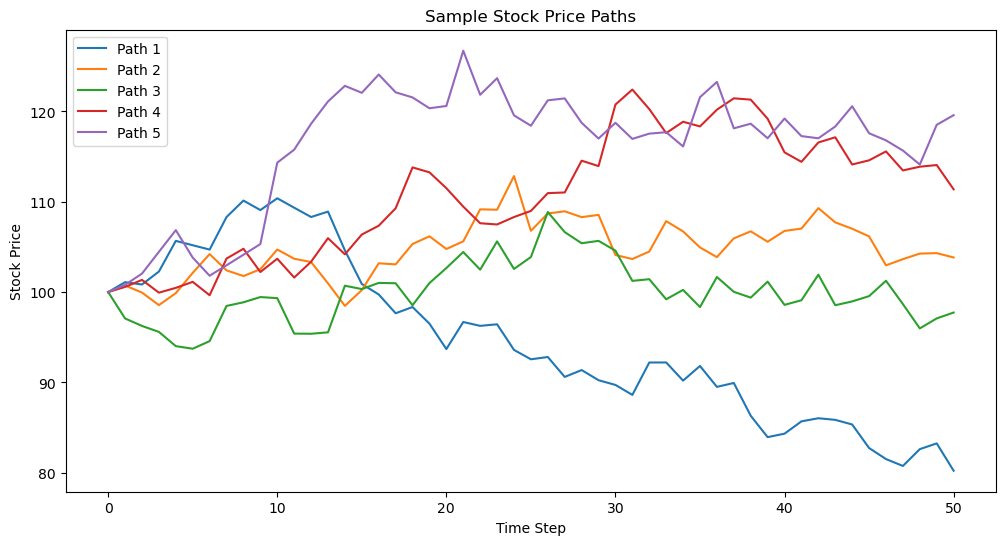

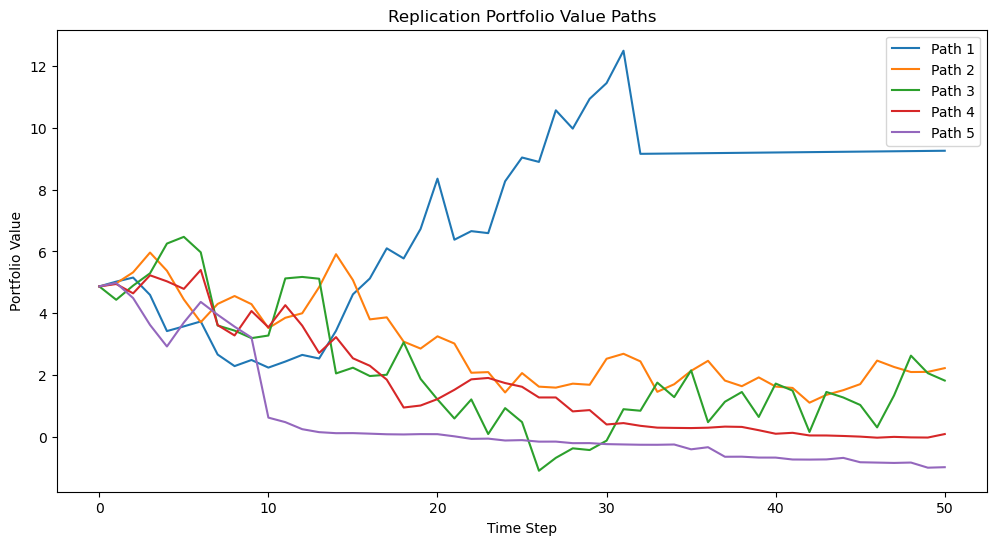

In [15]:
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(S[i], label=f"Path {i+1}")
plt.title("Sample Stock Price Paths")
plt.xlabel("Time Step")
plt.ylabel("Stock Price")
plt.legend()
plt.savefig("Sample Stock Price Paths(FQI).png")
plt.show()

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.plot(portfolio[i], label=f"Path {i+1}")
plt.title("Replication Portfolio Value Paths")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value")
plt.legend()
plt.savefig("Replication Portfolio Value Paths(FQI).png")
plt.show()

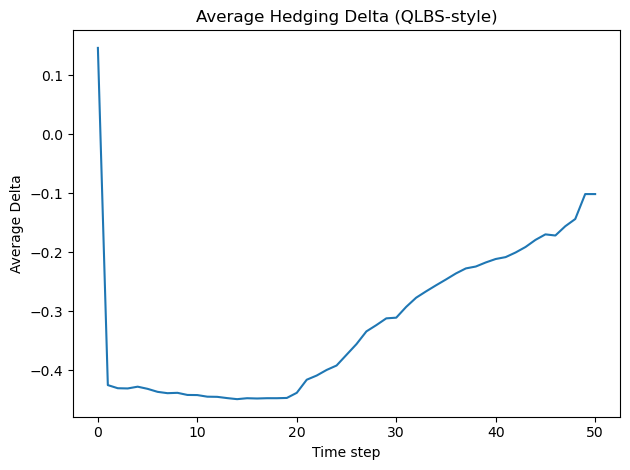

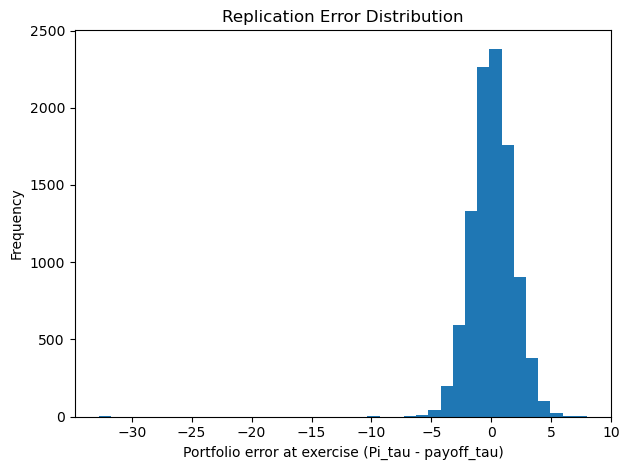

In [16]:
avg_delta = hedge.mean(axis=0)
y_vals = np.append(avg_delta, avg_delta[-1])

plt.figure()
plt.plot(np.arange(T+1), y_vals)
plt.xlabel('Time step'); plt.ylabel('Average Delta'); plt.title('Average Hedging Delta (QLBS-style)'); plt.tight_layout()
plt.savefig("Average Hedging Delta (FQI-style).png")
plt.show()

plt.figure()
plt.hist(portfolio_error, bins=40)
plt.xlabel('Portfolio error at exercise (Pi_tau - payoff_tau)'); plt.ylabel('Frequency'); plt.title('Replication Error Distribution'); plt.tight_layout()
plt.savefig("Replication Error Distribution(FQI).png")
plt.show()